## Executive Summary

This report presents the results of a churn prediction analysis for a telecommunications provider. Using a machine learning model trained on customer data, we identify individuals most at risk of leaving. By targeting the top 30% of high-risk customers, the business can potentially retain nearly 90% of all churners. Key churn drivers include monthly charges, contract type, and access to support services.

## Business Objective

The goal of this project is to help reduce customer churn by predicting which customers are most likely to leave, and by identifying key factors influencing those decisions. The insights are intended to support more targeted and cost-effective customer retention strategies.

## Dataset Summary

- Total Customers: 7,043
- Target Variable: `Churn` (Yes/No)
- Features include: Tenure, MonthlyCharges, TotalCharges, Contract Type, Internet Service, Tech Support, Online Security, ect.
- Churn Rate: ~27%

## Key Insights

- **Month-to-month contracts** are a major driver of churn as they strongly correlate with SHAP values pushing churn liklihood upwards. Comparatively customers with longer contracts are typically more likely to stay.
- Higher **monthly charges** associated with churners whilst higher **total charges** reduce churn risk (typically associated with longer tenure) - suggests pricing tolerance threshold for monthly charges.
- Customers without **Tech support or Online security** are more likely to churn. E.g. Customers without online security possed 1,461 churners compared to 295 who had the service - a ~5x difference
- **Fiber optic** customers churn more than **DSL** - possibly due to higher prices or unmet speed/reliability expectations.


## Cumulative Gains & Lift Analysis

- Targeting top **30%** of customers by churn risk captures **89.6%** of actual churners.
- To capture **95%**, you need to target the top **34%**.
- **Lift in the top 10%** is **~3.5×** — targeting customers in this percentile is ~3.5x more effective than random selection. 


## Strategic Recommendations

- Incentivise month-to-month contract users to switch to longer plans utilising targeted offers or fixed rate contracts.
- Promote bundle services: bundle tech support and online security for high risk customers.
- Monitor customers with **high monthly charges and low tenure** - particularly those identified as being high risk.
- Fiber optic investigation: investigate churn causes amongst users and adjust expectations/offers accordingly.
- Prioritise top ~30% for marketing and retention efforts for best ROI.

## Model Overview
A CatBoost classifier was used for churn prediction, with Optuna-based optimisation focusing on F1 score due to class imbalance. The model was evaluated on a hold-out test using standard evaluation metrics.
- Final model performance on test data:
  - **Accuracy**: 88%
  - **Recall (Churn class)**: 96%
  - **AUC**: 0.96
  - **Cohen Kappa**: 0.73

The table bellow provides the full model evaluation. Overall, the model is highly effective at distinguishing churners and non-churners and ranking them by risk probability.

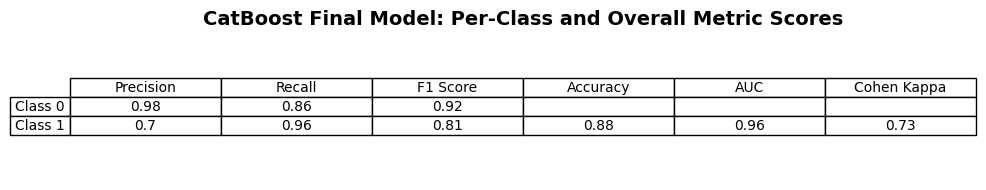

In [5]:
import os
os.chdir(r"C:\Users\tjsla\OneDrive\Desktop\Personal projects\Telco cutomer churn\Scripts") 
from check_zeros_nas import check_zeros_nas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, cv, Pool
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from evaluate_classification_binary_custom_threshold import evaluate_model_custom_threshold
import optuna
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, cohen_kappa_score, confusion_matrix
import shap

churn_original = pd.read_csv(r"C:\Users\tjsla\OneDrive\Desktop\Personal projects\Telco cutomer churn\Data\WA_Fn-UseC_-Telco-Customer-Churn.csv")
churn_copy = churn_original.copy()

entry_info = check_zeros_nas(churn_copy, verbose=False)

churn_copy['TotalCharges'] = churn_copy['TotalCharges'].astype(str).str.strip()
churn_copy['TotalCharges'] = churn_copy['TotalCharges'].replace("",np.nan)

na_row_dict = entry_info['row_indexes']['nas']
drop_rows = sorted(set(index for indices in na_row_dict.values() for index in indices))
churn_copy = churn_copy.drop(index=drop_rows)
churn_copy['TotalCharges'] = churn_copy['TotalCharges'].astype(float)
churn_copy = churn_copy.drop('customerID', axis = 1)
churn_copy['TotalCharges'] = np.log(churn_copy['TotalCharges'])
churn_copy['SeniorCitizen'] = churn_copy['SeniorCitizen'].map({1: 'Yes', 0: 'No'})
churn_copy['Churn'] = churn_copy['Churn'].map({'Yes': 1, 'No': 0})

churn_catboost = churn_copy.copy()

target_cat = churn_catboost['Churn']
feature_cat = churn_catboost.drop('Churn', axis = 1)

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(feature_cat, target_cat, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=1)
cat_features = X_train_cat.select_dtypes(include=['object', 'category']).columns.tolist()

best_model_cat = CatBoostClassifier()
best_model_cat.load_model("best_catboost_model.cbm")

probs = best_model_cat.predict_proba(X_test_cat)[:, 1]
threshold = 0.6
preds_custom = (probs >= threshold).astype(int)

cat_eval_optim_06 = evaluate_model_custom_threshold(best_model_cat, X_test_cat, y_test_cat,threshold=0.6, plot_roc=False,plot_cm=False)

class_metrics = {
    "Precision": cat_eval_optim_06["precision_per_class"],
    "Recall": cat_eval_optim_06["recall_per_class"],
    "F1 Score": cat_eval_optim_06["f1_score_per_class"]
}

# Extract overall metrics
overall_metrics = {
    "Accuracy": round(cat_eval_optim_06["accuracy"], 2),
    "AUC": round(cat_eval_optim_06["auc"], 2),
    "Cohen Kappa": round(cat_eval_optim_06["cohen_kappa"], 2)
}

# Build rows manually
data = [
    [
        class_metrics["Precision"]["class_0"],
        class_metrics["Recall"]["class_0"],
        class_metrics["F1 Score"]["class_0"],
        "", "", ""  # Leave overall metrics blank for class 0
    ],
    [
        class_metrics["Precision"]["class_1"],
        class_metrics["Recall"]["class_1"],
        class_metrics["F1 Score"]["class_1"],
        overall_metrics["Accuracy"],
        overall_metrics["AUC"],
        overall_metrics["Cohen Kappa"]
    ]
]

# Column labels
columns = [
    "Precision", "Recall", "F1 Score",
    "Accuracy", "AUC", "Cohen Kappa"
]
row_labels = ["Class 0", "Class 1"]

# Create DataFrame
df = pd.DataFrame(data, columns=columns, index=row_labels).round(2)

# Plot the table
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('off')

table = ax.table(
    cellText=df.values,
    rowLabels=df.index,
    colLabels=df.columns,
    cellLoc='center',
    rowLoc='center',
    loc='center'
)

# Format table appearance
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

plt.title("CatBoost Final Model: Per-Class and Overall Metric Scores", fontweight='bold', fontsize=14)
plt.tight_layout()
plt.show()

## Considerations
- Model effectiveness relies upon timely up to date data. Retraining necessary for optimal results - likely annually or bi-annually.
- Despite model effectiveness always a chance for non-churning customers to be pooled with churner retention efforts.
- Dataset may reflect biases based on regional, economic and demographic differences. Suggest future data incorporates these factors.

## Appendix
Supporting graphics can be found here such as: 
- SHAP summary plot: Highlights most contributing features.
- Feature importance chart: Ranks features on relative importance.
- Cumulative gains chart: Shows percentage of churners captured by percentile.
- Lift chart: measures model effectivenss over random targeting.
- Probability distribution plot: Shows predicted liklihoods of customers churning and whether they did/didn't.

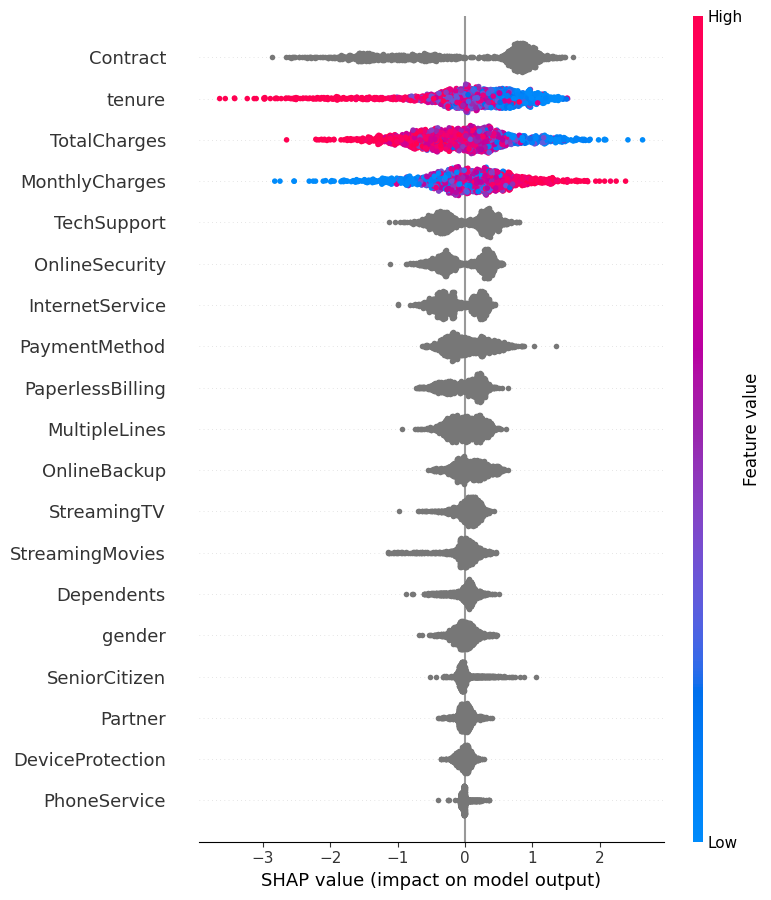

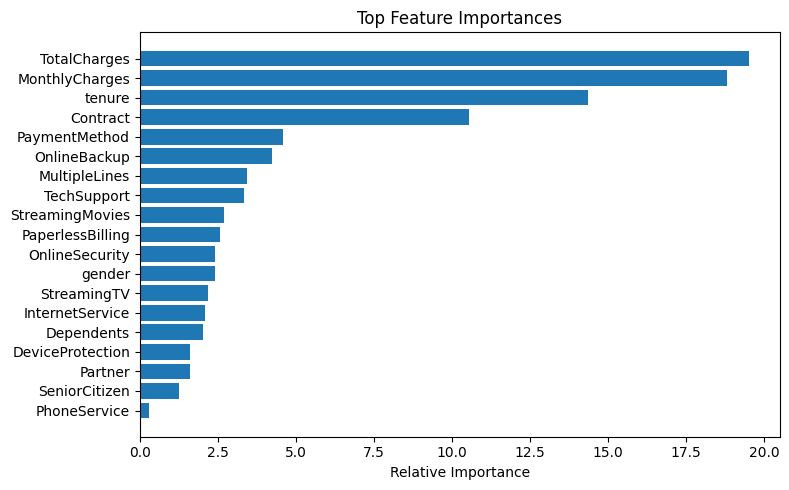

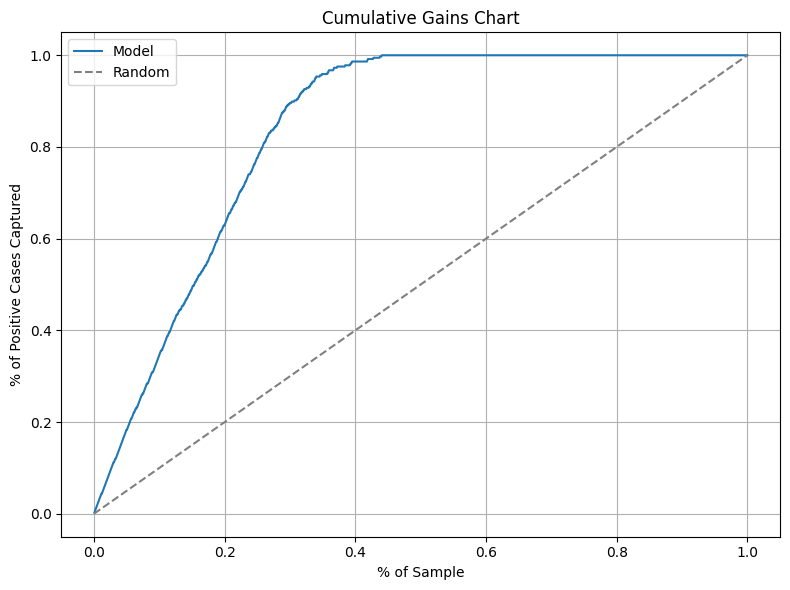

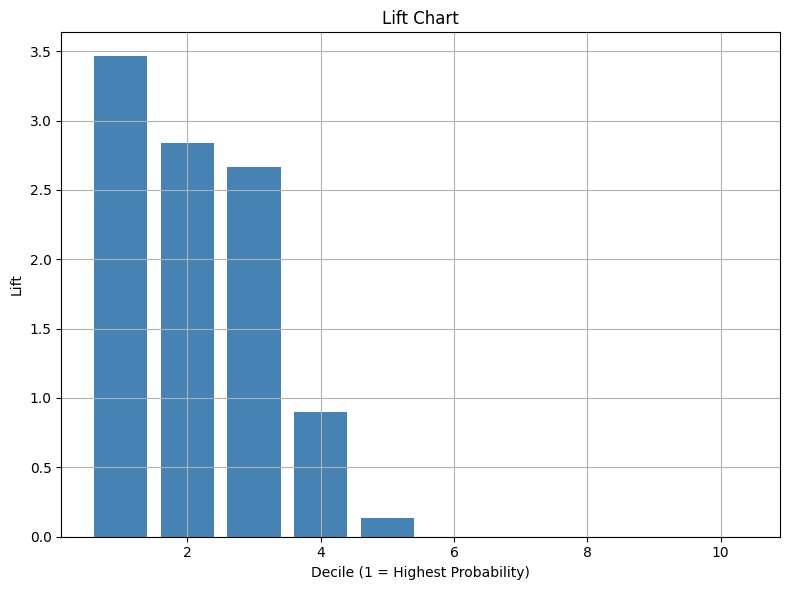

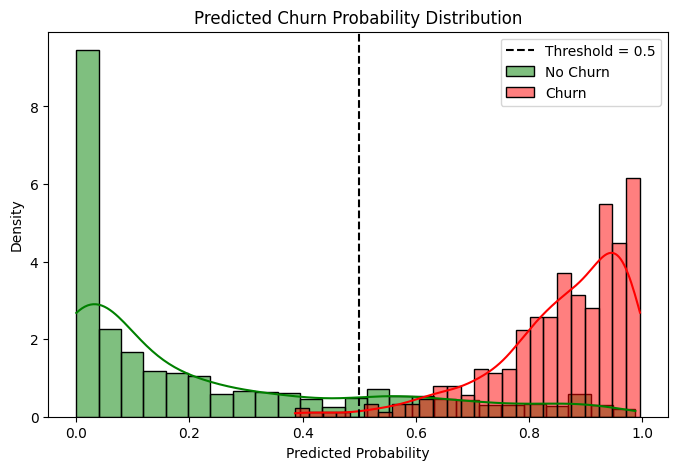

In [6]:
explainer = shap.TreeExplainer(best_model_cat)
shap_values = explainer(X_test_cat)

shap.summary_plot(shap_values, X_test_cat,show=False)

def plot_feature_importance(model, feature_names, top_n=10):
    importances = model.get_feature_importance()
    indices = np.argsort(importances)[-top_n:]
    plt.figure(figsize=(8, 5))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.title('Top Feature Importances')
    plt.tight_layout()
    plt.show()
    
plot_feature_importance(best_model_cat, feature_cat.columns, top_n=19)

def plot_cumulative_gain(y_true, y_prob, pos_label=1):
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values('y_prob', ascending=False).reset_index(drop=True)

    df['cumulative_positives'] = df['y_true'].cumsum()
    df['total_positives'] = df['y_true'].sum()
    df['gain'] = df['cumulative_positives'] / df['total_positives']

    pct_samples = np.arange(1, len(df)+1) / len(df)

    plt.figure(figsize=(8,6))
    plt.plot(pct_samples, df['gain'], label='Model')
    plt.plot([0, 1], [0, 1], '--', label='Random', color='gray')
    plt.xlabel('% of Sample')
    plt.ylabel('% of Positive Cases Captured')
    plt.title('Cumulative Gains Chart')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return values so we can use them for precise calculations
    return pct_samples, df['gain'].values

pct_samples, gains = plot_cumulative_gain(y_test_cat, probs)

def plot_lift_chart(y_true, y_prob, pos_label=1, bins=10):
    df = pd.DataFrame({'y_true': y_true, 'y_prob': y_prob})
    df = df.sort_values('y_prob', ascending=False).reset_index(drop=True)
    
    df['bucket'] = pd.qcut(df.index, q=bins, labels=False)
    grouped = df.groupby('bucket')['y_true'].agg(['sum', 'count'])
    grouped['response_rate'] = grouped['sum'] / grouped['count']
    
    baseline = df['y_true'].mean()
    grouped['lift'] = grouped['response_rate'] / baseline

    plt.figure(figsize=(8,6))
    plt.bar(range(1, bins+1), grouped['lift'], color='steelblue')
    plt.xlabel('Decile (1 = Highest Probability)')
    plt.ylabel('Lift')
    plt.title('Lift Chart')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_lift_chart(y_test_cat, probs)

def plot_probability_distribution(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]
    plt.figure(figsize=(8, 5))
    sns.histplot(y_prob[y_test == 0], color='green', label='No Churn', kde=True, stat="density", bins=25)
    sns.histplot(y_prob[y_test == 1], color='red', label='Churn', kde=True, stat="density", bins=25)
    plt.axvline(0.5, color='black', linestyle='--', label='Threshold = 0.5')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title('Predicted Churn Probability Distribution')
    plt.legend()
    plt.show()

plot_probability_distribution(best_model_cat, X_test_cat, y_test_cat)